# Machine-learning pipeline and prediction

In [ ]:
# 
# Pipeline for Kaggle contest
# by Khaydarov A., Tarasov N., Alexeev V. 
# 

In [6]:
import re
import ast
import shutil
import os
import pickle
import time
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from functools import partial
from pymystem3 import Mystem
from datetime import datetime
from catboost import CatBoostClassifier
from multiprocessing import Pool, cpu_count
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, make_scorer


train_dataset_path = './data/train.tsv'
test_dataset_path = './data/test_nolabel.tsv'
random_state = 228

In [2]:
df_train = pd.read_csv(train_dataset_path, sep='\t', index_col=0).reset_index().drop(columns='index')
df_train

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_id,product_type,properties,region,sold_mode,subcategory_id,sold_fast
0,4,Краснодар,2018-10-08,False,"Продаю стол раскладной, деревянный, советский ...",3,45.0686,38.9518,Стол,4ce583fe8231a0cc4a3c7d241c7d0289,True,500.0,8cb80c05c65c210275f5500779d6b593,1,"[{'slug_id': 'stoly_stulya_tip', 'slug_name': ...",Краснодарский край,1,410,1
1,4,Тюмень,2018-06-18,False,"Тарелки глубокие 6 шт. Блюдца, чашки по 6 шт. ...",2,57.1840,65.5674,Посуда,e58be2c8f143c17246dc2243b5d3b98f,False,300.0,3b7a9f8b27a53b63525f95bc8070abb2,1,"[{'slug_id': 'dom_dacha_posuda_tip', 'slug_nam...",Тюменская область,1,405,0
2,9,Омск,2018-07-31,True,"Новый,с этикеткой. Размер L. Не подошёл по раз...",1,54.9889,73.4312,Костюм,51b408796027214232532b7e478e2159,True,1100.0,c97dd9c5a3e938c52cf5d7822bc0eb7b,1,[{'slug_id': 'zhenskaya_odezhda_pidzhaki_kosty...,Омская область,1,908,0
3,3,Санкт-Петербург,2018-04-17,False,"Складывается тростью, все колеса вниз. Сплошна...",4,59.9590,30.4877,Коляска,6544b83acbbf04439a7ba983093cafb4,True,5000.0,3e5d0286b25fd7f62f88bc436a59ae4e,1,"[{'slug_id': 'waggon_type', 'slug_name': 'Тип'...",Ленинградская область,1,312,0
4,5,Москва,2018-02-09,False,"Неразлучники, птичкам по 1,5 года. Продаю с бо...",2,55.6473,37.4118,Волнистые попугаи,ea575e28daf1f47bfce63015cd3ce5cf,True,2000.0,57b4a8679d0d3eb1e31367b57221098f,1,[],Московская область,1,504,0
5,11,Гусь-Хрустальный,2018-04-28,False,"Продам детский велосипед,двухколесный,лет для ...",1,55.6063,40.6564,Велосипед детский,9ba6bb7a01bf0e577a36682da64a5dde,True,800.0,c73fd3f12f71c73ad4fa9c1b4b4f3629,1,"[{'slug_id': 'sport_tzvet', 'slug_name': 'Цвет...",Владимирская область,1,1107,0
6,5,Якутск,2018-02-08,False,"Отдам кота, 8 месяцев, к горшку приучен.",1,62.0355,129.6755,скоттиш страйт,7e0e13efb64cfbb1daf62a87ed63bf1f,False,1.0,be19161f29cc7e6e1795f756ef9e29e0,1,"[{'slug_id': 'koshki_poroda', 'slug_name': 'По...",Республика Саха (Якутия),1,503,0
7,13,Краснодар,2018-10-14,False,ТВ в рабочем состоянии,3,45.0618,38.9170,LE32R72B,e8e578f2dd291cc1b2e5944cb869028a,False,6000.0,c76ee67dfc81c0f06a3d908370a2f59e,1,"[{'slug_id': 'televizory_marka', 'slug_name': ...",Краснодарский край,1,1302,0
8,25,Орск,2018-06-02,False,1991 г.в.Пробег около 20000 км. Документы есть...,2,51.2585,58.6035,Минск,a992d673ee26064a0e9d157296244739,False,15000.0,c19620c06a40e40445854c4f665416da,1,"[{'slug_id': 'motocikly_skutery_tip', 'slug_na...",Оренбургская область,1,2503,0
9,2,Москва,2018-06-20,False,Продаю срочно бу хорошем состоянии два по 1.5 ...,3,55.8134,37.5958,Холодильники бу,fd9f4d97a20b9d279de9b45ba78d5874,True,12000.0,22670ae3efc3d73a3bec355ce05561ea,1,"[{'slug_id': 'oborudovanie_tip', 'slug_name': ...",Московская область,1,202,0


In [3]:
df_test = pd.read_csv(test_dataset_path, sep='\t', index_col=0).reset_index().drop(columns='index')
df_test

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_id,product_type,properties,region,sold_mode,subcategory_id
0,9,Челябинск,2018-10-22,True,"Ботильоны канадские 34 размер (35,но маломерят...",3,55.2639,61.3972,Ботильоны,4ec4746e62084fba6280d6651099f316,True,650.0,86156cd607c3238af8982aebc99ae6a5,1,"[{'slug_id': 'sostojanie_garderob', 'slug_name...",Челябинская область,1,902
1,22,Барнаул,2018-11-09,True,"Зимний костюм. Куртка в отличном состоянии, на...",2,53.3426,83.7380,Зимний костюм,180b02e19c8c0140bcd9e719fee0eb2d,True,750.0,76a35a1b4a2d869abfda3365d7cd4c45,1,"[{'slug_id': 'detskie_pol', 'slug_name': 'Пол'...",Алтайский край,1,2204
2,12,Чита,2018-11-27,False,"Продам прекрасный, стильный и шустрый смартфон...",4,52.0883,113.4982,"5.5"" Смартфон Prestigio Grace R5 LTE 16 гб зол...",b9b9b1e11e85acfd5c26e0e51bc734be,True,5500.0,c339765b077a730a5367c5310c64128d,1,"[{'slug_id': 'smartfony_3g', 'slug_name': '3G'...",Забайкальский край,1,1202
3,3,Москва,2018-11-25,True,Горка для купания на присосках. После одного м...,2,55.6932,37.5684,Горка для купания,88c125a4cfa8b806b8ce647b2e2f57da,True,100.0,b3ec786129b0b3bd7dcbce29d6d6232d,1,[],Московская область,1,316
4,22,Бердск,2018-11-04,True,Новый! В наличии! Размер 90 см Доставка по Бер...,2,54.7648,83.0884,Новый костюм,d82287641ee83c962ee0b427031f35d0,True,700.0,751a58cadb565feb070c2a29dd401438,1,"[{'slug_id': 'detskie_tzvet', 'slug_name': 'Цв...",Новосибирская область,1,2214
5,11,Хабаровск,2018-12-02,True,Спортивный комплекс выдерживает нагрузку до 10...,2,48.4499,135.1142,Продам спортивый комплекс,1b8b87976209f941f49acf5fb68ae1f5,True,4500.0,b11cb67a88b953548a0387d9c711ac1c,1,"[{'slug_id': 'trenazhery_fitnes_tip', 'slug_na...",Хабаровский край,1,1103
6,22,Санкт-Петербург,2018-10-27,True,"Вещи в хорошем состоянии. Выстираны, поглажены...",4,60.0149,30.4036,"Детские вещи (боди,кофта,футболка,полукомбинезон)",21c6c6683cbaf47d5d25fde51a5668f7,True,500.0,7280ec64d8c4a5f7bc875125e0a12a98,1,[],Ленинградская область,1,2201
7,15,Нижний Новгород,2018-12-20,False,Ноутбуку 3 года. Имеются царапины на лицевой с...,3,56.2950,43.9190,Ноутбук HP Pavilion,c09d53692f3fa159bf755717409b0eb4,False,8000.0,40f4873e0a467aa76235c32c444de893,1,"[{'slug_id': 'ram_memory', 'slug_name': 'Опера...",Нижегородская область,1,1504
8,14,Москва,2018-11-29,True,"Оригинал 100% , не пользовалась ими , жаль сто...",2,55.6454,37.4730,YSL Manifesto L'Elixir Оригинал,05a619abf1042bbf84cb18dc9bbf7bef,True,1500.0,6b9a056beb3ce44d13175755899710b7,1,"[{'slug_id': 'parfyumeriya_pol', 'slug_name': ...",Московская область,1,1403
9,8,Москва,2018-11-04,False,Новые,3,55.7552,37.5060,Брюки для зимы,14862d3a59bc89a58cb6ba4b26eb3f2b,True,750.0,84bac182bb4beba28b0d2497d528e6f9,1,"[{'slug_id': 'muzhskaya_odezhda_tzvet', 'slug_...",Московская область,1,809


In [4]:
def drumlog(msg):
    print('DrumRoller: ' + str(msg))

def Rollit(message):
    def decorator(method):
        def rolled(*args, **kw):
            drumlog(str(message) + '...')
            
            ts = time.time()
            result = method(*args, **kw)
            te = time.time()
            
            drumlog('done ' + method.__name__ + ' in ' + str(te - ts) + 's.')
            
            return result
        return rolled
    return decorator

def get_cache_path(log_name, cache_path='./cache/'):
    if not os.path.exists(cache_path):
        os.makedirs(cache_path)
    return cache_path + log_name + '.p'


def cache(obj, log_name):
    path = get_cache_path(log_name)

    try:
        with open(path, 'wb') as file:
            pickle.dump(obj, file)
    except (OSError, IOError) as e:
        drumlog('error writing file (' + log_name + ') . Raw message: ' + e.strerror)
        return False

    return True


def get_from_cache(log_name):
    path = get_cache_path(log_name)
    result = None

    try:
        with open(path, 'rb') as file:
            result = pickle.load(file)
    except (OSError, IOError) as e:
        drumlog('no cache of ' + log_name + ' found. Raw message: ' + e.strerror)
    
    return result

def Cacheit(log_name):
    def decorator(method):
        def cache_applied(*args, **kw):
            drumlog('trying to get ' + log_name + ' from disk cache...')
            cached = get_from_cache(log_name)

            if cached is not None:
                drumlog('applying cached values for ' + log_name + '.')
                return cached
            else:
                drumlog('no cache file for ' + log_name + ' found. Calling the method.')
            
            result = method(*args, **kw)
            
            if result is None:
                drumlog(log_name + ' method calling resulted in unexpected value. Caching is not applied.')
                return result
            
            is_cached = cache(result, log_name)
            
            if is_cached:
                drumlog(log_name + ' cached successfully.')
            else:
                drumlog(log_name + ' caching failure.')
            
            return result
        return cache_applied
    return decorator

def clear_cache(cache_path='./cache/'):
    try:
        shutil.rmtree(cache_path)
    except FileNotFoundError:
        pass


def split_array_like(arr_like, n_pieces=cpu_count()):
    piece_len = len(arr_like) // n_pieces
    rem = len(arr_like) % n_pieces
    return [arr_like[i * piece_len :] if i + 1 == n_pieces else arr_like[i * piece_len : (i+1) * piece_len] for i in range(n_pieces)]

In [15]:
output_dir = './submissions/'

class DrumRoller:
    def __init__(self, extract_features=['category_id', 'subcategory_id', 'region', 'city', 'date_created', 'delivery_available', 'text', 'img_num', 'lat', 'long', 'owner_id', 'payment_available', 'price', 'product_type', 'sold_mode'], target='sold_fast', properties=True, dense=False, apply_count_encoding=True, boosted_bad_from=0.15, boosted_good_from=0.3, boosted_threshold=90):
        drumlog('init')
        self.X = None
        self.X_test = None
        self.y = None

        self.features = extract_features
        self.with_properties = properties
        self.ord_encode = apply_count_encoding
        self.target = target
        self.is_dense = dense
        self.boosted_threshold = boosted_threshold
        self.boosted_good_from = boosted_good_from
        self.boosted_bad_from = boosted_bad_from

        self.prop_idx_mapping = None
        self.cat_features = None
        self.vector_length = None
        self.inverse_vocabulary = None
        self.boosted_terms = None

        self.city_tokenizer = None
        self.region_tokenizer = None
        self.owner_tokenizer = None
        self.tf_idf = None
        self.top_word_tokenizer = None

    # Complete & tested
    @staticmethod
    @Rollit('transforming main features to sparse matrix')
    def features_to_sparse(ds, column_names=[], cat_features=[]):
        ds_filtered = ds[column_names]
        categorical = [i if feature in cat_features else None for i, feature in enumerate(list(ds_filtered))]
        categorical = list(filter(lambda x: x is not None, categorical))

        sparse_matrix = sparse.coo_matrix(ds_filtered.values)

        return sparse_matrix, np.array(categorical)
    
    # Complete & tested
    @staticmethod
    @Rollit('transforming properties to sparse matrix')
    def get_properties_sparse(ds, n_rows, prop_idx_mapping={}, cat_features_offset=0):
        props_col = ds['properties']
        row = []
        col = []
        data = []
        cat_features = []

        drop_unknown = len(prop_idx_mapping) > 0

        # Если value_id == value_name тогда значение числовое, иначе категорийное
        def get_kv_val(val, val_id):
            try:
                if float(val) == float(val_id):
                    return val_id, False
            except ValueError:
                pass

            return val_id, True

        # Заполняем табличку
        def extend_output(prop, row_idx, col_idx):
            val, is_cat = get_kv_val(prop['value'], prop['value_id'])

            if prop['slug_id'] not in prop_idx_mapping:
                if drop_unknown:
                    return col_idx

                prop_idx_mapping[prop['slug_id']] = col_idx
                col_idx += 1

                if is_cat:
                    cat_features.append(prop_idx_mapping[prop['slug_id']])

            row.append(row_idx)
            col.append(prop_idx_mapping[prop['slug_id']])
            data.append(val)
            
            return col_idx

        col_idx = 0

        for row_idx, lit in props_col.iteritems():
            props = []

            try:
                props = ast.literal_eval(lit)
            except ValueError:
                print(lit)
                raise

            for prop in props:
                col_idx = extend_output(prop, row_idx, col_idx)

        return sparse.coo_matrix((data, (row, col)), shape=(n_rows, len(prop_idx_mapping))), np.array(cat_features) + cat_features_offset, prop_idx_mapping
    
    # Complete & tested
    @staticmethod
    def count_words(text):
        return len(re.split('\W+', text))
    
    # Complete & tested
    @staticmethod
    def count_sentences(text):
        return len(re.split('[.]+', text))
    
    # Complete & tested
    @staticmethod
    def count_paragraphs(text):
        return len(list(filter(len, re.split('[\n]+', text))))

    # Complete & tested
    @staticmethod
    def filter_analysis(obj):
        return (
            'analysis' in obj and len(obj['analysis']) and
            'gr' in obj['analysis'][0] and
            re.match('ANUM|COM|NUM|A|S', obj['analysis'][0]['gr']) is not None and
            len(obj['analysis'][0]['lex']) > 1
        )
    
    @staticmethod
    def make_analysis(text, stem):
        analysis = None
        
        for _ in range(5):
            try:
                analysis = stem.analyze(text)
            except BrokenPipeError:
                stem = Mystem()
            if analysis is not None:
                break
        
        if analysis is None:
            raise ValueError('Mystem shits')
        
        return list(map(lambda o: o['analysis'][0]['lex'], filter(DrumRoller.filter_analysis, analysis)))
    
    @staticmethod
    def process_vocabulary(data):
        stem = Mystem()

        vocabulary = list(map(partial(DrumRoller.make_analysis, stem=stem), data))
        
        return vocabulary
    
    @staticmethod
    @Rollit('running parallel task')
    def split_run_parallel(fn, data):
        splitted_data = split_array_like(data)
        proceed = None

        with Pool(30) as p:
            proceed = p.map(fn, splitted_data)
        
        return list(itertools.chain(*proceed))

    @staticmethod
    @Cacheit('vocabulary')
    @Rollit('creating vocabulary')
    def get_vocabulary(corpus):
        return DrumRoller.split_run_parallel(DrumRoller.process_vocabulary, corpus)
    
    @staticmethod
    def get_norm(text, stem):
        no_punct = ' '.join(re.findall('[\w]+', text))
        norm = None

        for _ in range(5):
            try:
                norm = ' '.join(stem.lemmatize(no_punct))
            except BrokenPipeError:
                stem = Mystem()
            if norm is not None:
                break
        
        if norm is None:
            raise ValueError('Mystem shits')
        
        return norm
    
    @staticmethod
    def process_corpus(data):
        stem = Mystem()
        
        return list(map(partial(DrumRoller.get_norm, stem=stem), data))

    @staticmethod
    @Cacheit('corpus')
    @Rollit('creating corpus')
    def get_corpus(ds_test, ds_train):
        docs = (
            (ds_train['desc_text'] + ' ' + ds_train['name_text']).values.tolist() +
            (ds_test['desc_text'] + ' ' + ds_test['name_text']).values.tolist()
        )
        
        return DrumRoller.split_run_parallel(DrumRoller.process_corpus, docs)
    
    @staticmethod
    @Cacheit('tf-idf-vectorizer')
    @Rollit('fitting TF-IDF vectorizer')
    def get_vectorizer(corpus, vocabulary=None):
        tf_idf = TfidfVectorizer(vocabulary=vocabulary)
        tf_idf.fit(corpus)
        inverse_vocabulary = {v: k for k, v in tf_idf.vocabulary_.items()}
        
        return tf_idf, inverse_vocabulary
    
    @Rollit('getting top words')
    def get_top_words(self, tf_res):
        indices = np.array(np.argmax(tf_res, axis=1))

        return [str(self.inverse_vocabulary[ind[0]]) if ind[0] != 0 else '' for i, ind in enumerate(indices)]
    
    @staticmethod
    def get_column_vector(text, terms):
        return np.array([int(term in text) for term in terms])
    
    @staticmethod
    def process_boosted_columns(data, terms):
        return list(map(partial(DrumRoller.get_column_vector, terms=terms), data))
    
    @Rollit('getting boosted columns')
    def get_boosted_columns(data, terms):
        return np.array(DrumRoller.split_run_parallel(partial(DrumRoller.process_boosted_columns, terms=terms), data))
    
    @staticmethod
    @Cacheit('boosted_terms')
    @Rollit('computing valuable terms')
    def get_boosted_terms(vocabulary_by_samples, ds_train, threshold, bad_from, good_from):
        train_vocabulary = vocabulary_by_samples[:len(ds_train)]
        sold_fast = np.array(train_vocabulary)[ds_train['sold_fast'].values.astype(bool)]
        
        # Flatten
        train_vocabulary = list(itertools.chain(*train_vocabulary))
        sold_fast = list(itertools.chain(*sold_fast))
        
        # Grouping & counting
        words, counts = np.unique(train_vocabulary, return_counts=True)
        words_sold_fast, counts_sold_fast = np.unique(sold_fast, return_counts=True)
        
        pairs_wc = [(x, y) for y, x in sorted(zip(counts, words))]
        pairs_soldfast_wc = [(x, y) for y, x in sorted(zip(counts_sold_fast, words_sold_fast))]
        
        # DF
        df_full = pd.DataFrame(pairs_wc).set_index(0)
        df_soldfast = pd.DataFrame(pairs_soldfast_wc).set_index(0)
        
        # joining
        
        df_terms = df_soldfast.join(df_full.rename(columns={1:2}), how='outer').fillna(0.)
        df_terms['impact'] = df_terms[1] / df_terms[2]
        
        df_terms_filtered = df_terms[(df_terms[1] > 90) & (df_terms['impact'] > 0.25)]
        
        return df_terms_filtered.reset_index()[0].values
    
    @Rollit('processing text data')
    def process_text(self, ds_test, is_train=True, ds_train=None):
        if is_train and ds_train is None:
            raise drumlog('No train ds for training')
        
        index = ds_test.index
        ds_main = ds_test
        cat_features = []
        column_names = None
        columns = None
        
        if is_train:
            ds_main = ds_train
            index = ds_train.index
        
        df = pd.DataFrame(index=index)
        
        df['description_count_char'] = ds_main['desc_text'].apply(len)
        df['description_count_word'] = ds_main['desc_text'].apply(DrumRoller.count_words)
        df['description_count_sen'] = ds_main['desc_text'].apply(DrumRoller.count_sentences)
        df['description_count_para'] = ds_main['desc_text'].apply(DrumRoller.count_paragraphs)

        df['title_count_char'] = ds_main['name_text'].apply(len)
        df['title_count_word'] = ds_main['name_text'].apply(DrumRoller.count_words)
            
        if is_train:
            corpus = DrumRoller.get_corpus(ds_test, ds_train)
            vocabulary = np.unique(list(itertools.chain(*DrumRoller.get_vocabulary(corpus))))
            self.tf_idf, self.inverse_vocabulary = DrumRoller.get_vectorizer(corpus, vocabulary)
            self.boosted_terms = DrumRoller.get_boosted_terms(DrumRoller.get_vocabulary(corpus), ds_train, threshold=self.boosted_threshold, good_from=self.boosted_good_from,bad_from=self.boosted_bad_from)

            cat_features += ['name_top_word', 'desc_top_word']
        
        drumlog('getting name_text normalized...')
        name_norm = DrumRoller.split_run_parallel(DrumRoller.process_corpus, ds_main['name_text'].values)
        drumlog('getting desc_text normalized...')
        desc_norm = DrumRoller.split_run_parallel(DrumRoller.process_corpus, ds_main['desc_text'].values)

        drumlog('applying tf_idf transform...')
        name = self.tf_idf.transform(name_norm)
        desc = self.tf_idf.transform(desc_norm)
        
        df['name_top_word'] = self.get_top_words(name)
        df['desc_top_word'] = self.get_top_words(desc)

        if self.ord_encode:
            if is_train:
                self.top_word_tokenizer = OrdinalEncoder()
                self.top_word_tokenizer.fit(np.array(np.unique(list(itertools.chain(*DrumRoller.get_vocabulary(corpus)))).tolist() + ['']).reshape(-1,1))

            df['name_top_word'] = self.top_word_tokenizer.transform(df['name_top_word'].values.reshape(-1,1))
            df['desc_top_word'] = self.top_word_tokenizer.transform(df['desc_top_word'].values.reshape(-1,1))
        
        if is_train:
            columns = DrumRoller.get_boosted_columns(DrumRoller.get_vocabulary()[:len(ds_main)], self.boosted_terms)
        else:
            columns = DrumRoller.get_boosted_columns(DrumRoller.get_vocabulary()[-len(ds_main):], self.boosted_terms)

        df[self.boosted_terms] = pd.DataFrame(columns)

        cat_features += self.boosted_terms.tolist()

        return df, cat_features
            
    @Rollit('processing features')
    def process_features(self, ds_test, is_train=True, ds_train=None):
        if is_train and ds_train is None:
            raise ValueError('DrumRoller: No train ds for training')
        
        index = ds_test.index
        ds_main = ds_test
        cat_features = []

        if is_train:
            index = ds_train.index
            ds_main = ds_train
        
        df = pd.DataFrame(index=index)
        
        # Категорийные фичи без кодирования
        
        if 'category_id' in self.features:
            df['category_id'] = ds_main['category_id']
            
            if is_train:
                cat_features.append('category_id')

        if 'subcategory_id' in self.features:
            df['subcategory_id'] = ds_main['subcategory_id']
            
            if is_train:
                cat_features.append('subcategory_id')

        if 'product_type' in self.features:
            df['product_type'] = ds_main['product_type']
            
            if is_train:
                cat_features.append('product_type')
            
        if 'sold_mode' in self.features:
            df['sold_mode'] = ds_main['sold_mode']
            
            if is_train:
                cat_features.append('sold_mode')
            
        # Категорийные фичи с кодированием
        
        if 'city' in self.features:
            if self.ord_encode:
                if is_train:
                    self.city_tokenizer = OrdinalEncoder()
                    self.city_tokenizer.fit(np.concatenate([ds_train['city'].values, ds_test['city'].values]).reshape(-1,1))
                    
                    cat_features.append('city')

                df['city'] = self.city_tokenizer.transform(ds_main['city'].values.reshape(-1,1))
            else:
                df['city'] = ds_main['city']
        
        if 'owner_id' in self.features:
            if self.ord_encode:
                if is_train:
                    self.owner_tokenizer = OrdinalEncoder()
                    self.owner_tokenizer.fit(np.concatenate([ds_train['owner_id'].values, ds_test['owner_id'].values]).reshape(-1,1))
                    
                    cat_features.append('owner_id')

                df['owner_id'] = self.owner_tokenizer.transform(ds_main['owner_id'].values.reshape(-1,1))
            else:
                df['owner_id'] = ds_main['owner_id']            
        
        if 'region' in self.features:
            if self.ord_encode:
                if is_train:
                    self.region_tokenizer = OrdinalEncoder()
                    self.region_tokenizer.fit(np.concatenate([ds_train['region'].values, ds_test['region'].values]).reshape(-1,1))
                    
                    cat_features.append('region')

                df['region'] = self.region_tokenizer.transform(ds_main['region'].values.reshape(-1,1))
            else:
                df['region'] = ds_main['region']
        
        # Булевые категорийные фичи
            
        if 'delivery_available' in self.features:
            df['delivery_available'] = ds_main['delivery_available'].astype(int)
            
            if is_train:
                cat_features.append('delivery_available')
            
        if 'payment_available' in self.features:
            df['payment_available'] = ds_main['payment_available'].astype(int)
            
            if is_train:
                cat_features.append('payment_available')
        
        # Числовые фичи

        if 'img_num' in self.features:
            df['img_num'] = ds_main['img_num']
        
        if 'lat' in self.features:
            df['lat'] = ds_main['lat']
        
        if 'long' in self.features:
            df['long'] = ds_main['long']
            
        if 'price' in self.features:
            df['price'] = ds_main['price']
        
        # Фича инжиниринг топ кек
        
        if 'date_created' in self.features:
            df['month'] = ds_main['date_created'].apply(lambda x: datetime.fromisoformat(x).month)
            df['day'] = ds_main['date_created'].apply(lambda x: datetime.fromisoformat(x).day)
        
        if 'text' in self.features:
            df_text, cf_text = self.process_text(ds_test, ds_train=ds_train, is_train=is_train)
            
            df = pd.concat([df, df_text], axis=1)
            cat_features += cf_text

        if is_train:
                return df, cat_features
        
        return df
    
    @Rollit('processing training dataset')
    def process_train_ds(self, ds_train, ds_test):
        self.y = ds_train[self.target].values
        df, cat_features = self.process_features(ds_test, ds_train=ds_train)
        self.X, self.cat_features = DrumRoller.features_to_sparse(df, list(df), cat_features)
        
        # Properties
        
        if self.with_properties:
            props_sparse, props_cat_features, self.prop_idx_mapping = DrumRoller.get_properties_sparse(ds_train, self.X.shape[0], cat_features_offset=self.X.shape[1])

            self.X = sparse.hstack([self.X, props_sparse])
            self.cat_features = np.concatenate([self.cat_features, props_cat_features])
        
        self.vector_length = self.X.shape[1]

        if self.is_dense:
            self.X = self.X.toarray()

        return self.X, self.y, self.cat_features
    
    @Rollit('processing test dataset')
    def process_test_ds(self, ds_test):
        ids = ds_test['product_id']
        
        if self.X_test is None:
            df = self.process_features(ds_test, is_train=False)

            self.X_test, _ = DrumRoller.features_to_sparse(df, list(df))

            if self.with_properties:
                props_sparse, _, __ = DrumRoller.get_properties_sparse(ds_test, self.X_test.shape[0], prop_idx_mapping=self.prop_idx_mapping)

                self.X_test = sparse.hstack([self.X_test, props_sparse])

            if self.is_dense:
                self.X_test = self.X_test.toarray()
        
        return self.X_test, ids.values

    @Rollit('making submission')
    def make_submission(self, clf, ds_test, dry_run=False):
        filename = output_dir + type(clf).__name__ + datetime.now().strftime('-%Y-%m-%d.%H-%M-%S.submission.csv')
        test_dataset, ids = self.process_test_ds(ds_test)
        
        if not dry_run:
            scores = clf.predict_proba(test_dataset)

            pd.DataFrame({'product_id': ids, 'score': scores[:, 1]}).to_csv(path_or_buf=filename, index=False)
            drumlog('submission created, file: ' + filename)
        else:
            drumlog('dryrunned')

In [19]:
# for plots

rollers = [
    # "Features with easy transorm"
    DrumRoller(extract_features=['category_id', 'subcategory_id', 'region', 'city', 'date_created', 'delivery_available', 'img_num', 'lat', 'long', 'owner_id', 'payment_available', 'price', 'product_type', 'sold_mode'], properties=False, dense=True),
    # "With properties"
    DrumRoller(extract_features=['category_id', 'subcategory_id', 'region', 'city', 'date_created', 'delivery_available', 'img_num', 'lat', 'long', 'owner_id', 'payment_available', 'price', 'product_type', 'sold_mode'], dense=True),
    # "Properties only"
    DrumRoller(extract_features=[], dense=True),
    # "Text only"
    DrumRoller(extract_features=['text'], properties=False, dense=True, ),
    # "With text"
    DrumRoller(properties=False, dense=True),
    # "Easy features & Text & Properties"
    DrumRoller(dense=True),
]

datasets = []

clear_cache()

for roller in rollers:
    X, y, cat_features = roller.process_train_ds(df_train, df_test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    datasets.append((X_train, X_test, cat_features, y_train, y_test))
    roller.make_submission(None, df_test, dry_run=True)
    print()


DrumRoller: init
DrumRoller: init
DrumRoller: init
DrumRoller: init
DrumRoller: init
DrumRoller: init
DrumRoller: processing training dataset...
DrumRoller: processing features...
DrumRoller: done process_features in 1.6921634674072266s.
DrumRoller: transforming main features to sparse matrix...
DrumRoller: done features_to_sparse in 0.28048133850097656s.
DrumRoller: done process_train_ds in 2.0166218280792236s.
DrumRoller: making submission...
DrumRoller: processing test dataset...
DrumRoller: processing features...
DrumRoller: done process_features in 0.505274772644043s.
DrumRoller: transforming main features to sparse matrix...
DrumRoller: done features_to_sparse in 0.06524872779846191s.
DrumRoller: done process_test_ds in 0.5756711959838867s.
DrumRoller: dryrunned
DrumRoller: done make_submission in 0.5762889385223389s.

DrumRoller: processing training dataset...
DrumRoller: processing features...
DrumRoller: done process_features in 1.6647579669952393s.
DrumRoller: transforming ma

DrumRoller: applying cached values for vocabulary.
DrumRoller: trying to get vocabulary from disk cache...
DrumRoller: applying cached values for vocabulary.
DrumRoller: getting boosted columns...
DrumRoller: running parallel task...
DrumRoller: done split_run_parallel in 23.842905521392822s.
DrumRoller: done get_boosted_columns in 24.67399311065674s.
DrumRoller: done process_text in 167.5781397819519s.
DrumRoller: done process_features in 170.27674341201782s.
DrumRoller: transforming main features to sparse matrix...
DrumRoller: done features_to_sparse in 4.4966936111450195s.
DrumRoller: done process_train_ds in 175.53930020332336s.
DrumRoller: making submission...
DrumRoller: processing test dataset...
DrumRoller: processing features...
DrumRoller: processing text data...
DrumRoller: getting name_text normalized...
DrumRoller: running parallel task...
DrumRoller: done split_run_parallel in 10.542865753173828s.
DrumRoller: getting desc_text normalized...
DrumRoller: running parallel t

In [26]:
cb = CatBoostClassifier(verbose=10, random_state=random_state, task_type = 'GPU', eval_metric='AUC', od_type='Iter', od_wait=100)

for i, ds in enumerate(datasets):
    X_train, X_test, cat_features, y_train, y_test = ds
    cf = cat_features.astype(int).tolist()

    cb.set_params(iterations=300, learning_rate=0.15, l2_leaf_reg=3, depth=6)

    cb.fit(X_train, y_train, cat_features=cf, eval_set=(X_test, y_test))


0:	learn: 0.6009145	test: 0.6072294	best: 0.6072294 (0)	total: 33.9ms	remaining: 10.1s
10:	learn: 0.6188021	test: 0.6242606	best: 0.6242606 (10)	total: 337ms	remaining: 8.85s
20:	learn: 0.6252881	test: 0.6302798	best: 0.6302798 (20)	total: 602ms	remaining: 8s
30:	learn: 0.6294354	test: 0.6337498	best: 0.6337498 (30)	total: 884ms	remaining: 7.67s
40:	learn: 0.6322622	test: 0.6358097	best: 0.6358097 (40)	total: 1.16s	remaining: 7.33s
50:	learn: 0.6336065	test: 0.6365644	best: 0.6365644 (50)	total: 1.44s	remaining: 7.04s
60:	learn: 0.6354654	test: 0.6374764	best: 0.6374764 (60)	total: 1.71s	remaining: 6.68s
70:	learn: 0.6369479	test: 0.6382041	best: 0.6382041 (70)	total: 1.99s	remaining: 6.41s
80:	learn: 0.6385649	test: 0.6389121	best: 0.6389121 (80)	total: 2.26s	remaining: 6.11s
90:	learn: 0.6398776	test: 0.6393182	best: 0.6393182 (90)	total: 2.54s	remaining: 5.82s
100:	learn: 0.6412033	test: 0.6397030	best: 0.6397030 (100)	total: 2.81s	remaining: 5.53s
110:	learn: 0.6426475	test: 0.6402

0:	learn: 0.5635969	test: 0.5735161	best: 0.5735161 (0)	total: 24.5ms	remaining: 7.34s
10:	learn: 0.5878374	test: 0.5985315	best: 0.5985315 (10)	total: 269ms	remaining: 7.06s
20:	learn: 0.5923295	test: 0.6023420	best: 0.6023420 (20)	total: 500ms	remaining: 6.64s
30:	learn: 0.5953104	test: 0.6041701	best: 0.6041701 (30)	total: 749ms	remaining: 6.5s
40:	learn: 0.5973275	test: 0.6050134	best: 0.6050134 (40)	total: 984ms	remaining: 6.21s
50:	learn: 0.5993206	test: 0.6058448	best: 0.6058448 (50)	total: 1.22s	remaining: 5.96s
60:	learn: 0.6013625	test: 0.6066325	best: 0.6066325 (60)	total: 1.45s	remaining: 5.68s
70:	learn: 0.6027043	test: 0.6070797	best: 0.6070797 (70)	total: 1.69s	remaining: 5.47s
80:	learn: 0.6040727	test: 0.6075954	best: 0.6075954 (80)	total: 1.93s	remaining: 5.22s
90:	learn: 0.6054492	test: 0.6076902	best: 0.6077078 (84)	total: 2.16s	remaining: 4.96s
100:	learn: 0.6068108	test: 0.6079658	best: 0.6079658 (100)	total: 2.4s	remaining: 4.72s
110:	learn: 0.6081042	test: 0.608

290:	learn: 0.6639201	test: 0.6489556	best: 0.6489556 (290)	total: 9.26s	remaining: 286ms
299:	learn: 0.6645965	test: 0.6487297	best: 0.6489794 (292)	total: 9.56s	remaining: 0us
bestTest = 0.6489793956
bestIteration = 292
Shrink model to first 293 iterations.


In [13]:
dr.make_submission(cb, df_test)

DrumRoller: making submission...
DrumRoller: processing test dataset...
DrumRoller: done process_test_ds in 4.220008850097656e-05s.
DrumRoller: submission created. File: ./submissions/CatBoostClassifier-2019-06-13.23-34-17.submission.csv
DrumRoller: done make_submission in 29.101742267608643s.


In [7]:
rollers = [
    # "Text only with more text"
    DrumRoller(extract_features=['text'], properties=False, dense=True, boosted_bad_from=0.17, boosted_good_from=0.27, boosted_threshold=90),
    # "Text only with more theshold"
    DrumRoller(extract_features=['text'], properties=False, dense=True, boosted_bad_from=0.18, boosted_good_from=0.27, boosted_threshold=100),
    # "Text only with more theshold"
    DrumRoller(extract_features=['text'], properties=False, dense=True, boosted_bad_from=0.0, boosted_good_from=0.25, boosted_threshold=90),
]

datasets = []

clear_cache()

for roller in rollers:
    X, y, cat_features = roller.process_train_ds(df_train, df_test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    datasets.append((X_train, X_test, cat_features, y_train, y_test))
    roller.make_submission(None, df_test, dry_run=True)
    print()

#n=300, lr=0.15, l2reg=3, depth=7


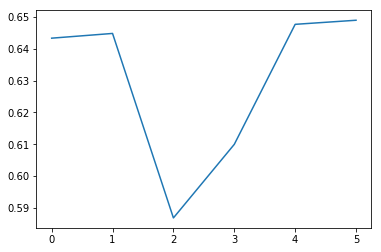

In [28]:
# 1. Simple features
# 2. s.f. with properties
# 3. Properties only
# 4. Text features only
# 5. s.f. with text features
# 6. s.f. with text features and properties

# Test split 
# n=300, lr=0.15, l2reg=7, depth=9
# 1. 0.6409924328
# 2. 0.6448206007
# 3. 0.5867868364
# 4. 0.607919991
# 5. 0.6464424729
# 6. 0.6480351985

# n=400, lr=0.1, l2reg=7, depth=9
# 1. 0.6412607133
# 2. 0.6447297931
# 3. 0.5868281722
# 4. 0.6077289283
# 5. 0.6477481723
# 6. 0.6494458616

# n=300, lr=0.15, l2reg=10, depth=10
# 1. 0.6396666169
# 2. 0.6422594786
# 3. 0.5868585706
# 4. 0.6060833931
# 5. 0.6465729475
# 6. 0.6471060216

# n=300, lr=0.15, l2reg=3, depth=7
# 1. 0.644066453
# 2. 0.644677788
# 3. 0.5858872533
# 4. 0.6090815067
# 5. 0.648298651
# 6. 0.6497089863

# n=400, lr=0.15, l2reg=3, depth=7
# 1. 0.643158555
# 2. 0.6446923912
# 3. 0.5868892372
# 4. 0.6090815067
# 5. 0.6482982934
# 6. 0.6494852602

# n=300, lr=0.15, l2reg=3, depth=6
# 1. 0.643342942
# 2. 0.6448304355
# 3. 0.5868297219
# 4. 0.6099580824
# 5. 0.647693336
# 6. 0.6489793956

data = [0.643342942, 
    0.6448304355,
    0.5868297219,
    0.6099580824,
    0.647693336,
    0.6489793956
]

plt.plot(data)
plt.show()